# Social Media Trend Analysis using Apache Spark

**Course:** DSC3108 – Big Data Mining and Analytics  
**Program:** BSc Computer Science  
**Platform:** Google Colab + Apache Spark  
**Dataset:** Airline Tweets (Tweets.csv)

---


In [1]:
# Install PySpark
!pip install -q pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("DSC3108-Social-Media-Trend-Analysis") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print("Spark Version:", spark.version)
print("Spark Master:", spark.sparkContext.master)


Spark Version: 4.0.1
Spark Master: local[*]


In [3]:
from pyspark.sql.functions import (
    col, to_timestamp, to_date, hour, date_format, month, year,
    regexp_replace, length, when, expr, count, avg, sum
)

from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, HashingTF, IDF,
    VectorAssembler, StringIndexer
)

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
    ClusteringEvaluator
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
from google.colab import files

uploaded = files.upload()


Saving Tweets.csv to Tweets.csv


In [5]:
df = spark.read.csv(
    "Tweets.csv",
    header=True,
    inferSchema=True
)

print("Rows:", df.count())
print("Columns:", len(df.columns))
df.printSchema()
df.show(5, truncate=False)


Rows: 14837
Columns: 15
root
 |-- tweet_id: string (nullable = true)
 |-- airline_sentiment: string (nullable = true)
 |-- airline_sentiment_confidence: string (nullable = true)
 |-- negativereason: string (nullable = true)
 |-- negativereason_confidence: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- airline_sentiment_gold: string (nullable = true)
 |-- name: string (nullable = true)
 |-- negativereason_gold: string (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- tweet_coord: string (nullable = true)
 |-- tweet_created: string (nullable = true)
 |-- tweet_location: string (nullable = true)
 |-- user_timezone: string (nullable = true)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------------------------------------------------------------------------

### Why this is a Big Data Problem

The dataset consists of large-scale, unstructured social media text data with
temporal and engagement attributes. Processing, cleaning, feature extraction,
and machine learning on such data require distributed computation, making
Apache Spark more suitable than traditional relational databases.


In [6]:
# Parse timestamp
df_clean = df.withColumn(
    "tweet_created_parsed",
    to_timestamp("tweet_created", "yyyy-MM-dd HH:mm:ss Z")
)

# Extract temporal features
df_clean = df_clean.withColumn("date", to_date("tweet_created_parsed")) \
    .withColumn("hour", hour("tweet_created_parsed")) \
    .withColumn("day_of_week", date_format("tweet_created_parsed", "EEEE"))

# Clean text
df_clean = df_clean.withColumn(
    "text_cleaned",
    regexp_replace(col("text"), r"http\S+|www\.\S+|@\w+", "")
).withColumn(
    "text_length",
    length(col("text"))
)

# SAFELY handle sentiment confidence (NO approxQuantile)
median_confidence = (
    df_clean
    .selectExpr("try_cast(airline_sentiment_confidence as double) AS conf")
    .where("conf IS NOT NULL")
    .agg(expr("percentile_approx(conf, 0.5) AS median"))
    .collect()[0]["median"]
)

df_clean = df_clean.withColumn(
    "airline_sentiment_confidence",
    expr(f"""
        coalesce(
            try_cast(airline_sentiment_confidence as double),
            {median_confidence}
        )
    """)
)

# Fill remaining nulls
df_clean = df_clean.fillna({
    "retweet_count": 0,
    "text": ""
})

print("Cleaned rows:", df_clean.count())
df_clean.select("airline_sentiment_confidence").summary().show()


Cleaned rows: 14837
+-------+----------------------------+
|summary|airline_sentiment_confidence|
+-------+----------------------------+
|  count|                       14837|
|   mean|          2.2609336119161605|
| stddev|          165.59040914414012|
|    min|                       0.335|
|    25%|                      0.6939|
|    50%|                         1.0|
|    75%|                         1.0|
|    max|                     20171.0|
+-------+----------------------------+



SECTION 8: Exploratory Analysis & Visualizations
8.1 Sentiment Distribution (Spark → Visualization)

In [7]:
# Spark aggregation
sentiment_counts = (
    df_clean
    .groupBy("airline_sentiment")
    .count()
    .orderBy(col("count").desc())
)

sentiment_counts.show()


+--------------------+-----+
|   airline_sentiment|count|
+--------------------+-----+
|            negative| 9178|
|             neutral| 3099|
|            positive| 2363|
|                NULL|  155|
|                   0|    8|
| this is where Ce...|    2|
|[35.23185283, -80...|    1|
|   ubetter do smth!"|    1|
| we had a good ru...|    1|
| never submits. F...|    1|
|[40.7740308, -73....|    1|
|     please????????"|    1|
| this is where Ce...|    1|
| flight AA1469 2/...|    1|
|[51.44284934, -0....|    1|
| or just days tha...|    1|
|[40.65062011, -73...|    1|
| and I might choo...|    1|
|            Virginia|    1|
|          [0.0, 0.0]|    1|
+--------------------+-----+
only showing top 20 rows


In [8]:
# Convert to pandas for plotting
sentiment_pd = sentiment_counts.toPandas()


In [10]:
sentiment_pd


,airline_sentiment,count
0,negative,9178
1,neutral,3099
2,positive,2363
3,None,155
4,0,8
5,this is where Cessna's become 747's! http://t...,2
6,"[35.23185283, -80.96487203]",1
7,"ubetter do smth!""",1
8,"we had a good run ✌️""",1
9,"never submits. For a couple weeks now.""",1


In [11]:
valid_sentiments = ["positive", "negative", "neutral"]

df_clean = df_clean.filter(
    col("airline_sentiment").isin(valid_sentiments)
)


In [12]:
sentiment_counts = (
    df_clean
    .groupBy("airline_sentiment")
    .count()
    .orderBy(col("count").desc())
)

sentiment_counts.show()


+-----------------+-----+
|airline_sentiment|count|
+-----------------+-----+
|         negative| 9178|
|          neutral| 3099|
|         positive| 2363|
+-----------------+-----+



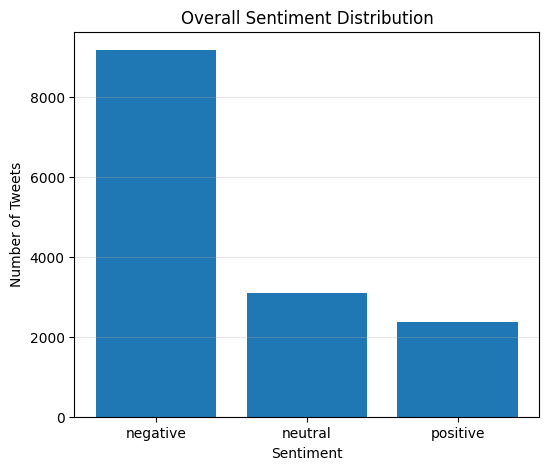

In [13]:
sentiment_pd = sentiment_counts.toPandas()

plt.figure(figsize=(6, 5))
plt.bar(
    sentiment_pd["airline_sentiment"],
    sentiment_pd["count"]
)
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.grid(axis="y", alpha=0.3)
plt.show()


### Interpretation: Overall Sentiment Distribution

The bar chart shows a clear dominance of negative sentiment in airline-related
tweets, significantly exceeding both neutral and positive sentiments.
Neutral tweets form a moderate portion of the dataset, while positive sentiment
is the least frequent.

This distribution indicates that customers are more likely to use social media
to express dissatisfaction or report service issues rather than to share positive
experiences. Such behavior is common in customer-facing industries, where
complaints and service disruptions prompt immediate public feedback.

From a business perspective, this highlights the importance of continuous
sentiment monitoring and rapid response mechanisms. The high volume of negative
sentiment suggests opportunities for airlines to improve customer experience,
address recurring issues, and mitigate reputational risk through proactive
engagement.


In [14]:
df_clean.cache()
print("Cached cleaned DataFrame")


Cached cleaned DataFrame


SECTION 11: Airline-Level Analysis
11.1 Tweet Volume by Airline

In [27]:
from pyspark.sql.functions import expr, col, to_date, hour, date_format, regexp_replace, length, when

df_clean = (
    df
    .select(
        "airline",
        "airline_sentiment",
        "airline_sentiment_confidence",
        "retweet_count",
        "text",
        "tweet_created"
    )
)


In [28]:
df_clean = df_clean.withColumn(
    "tweet_created_parsed",
    expr("try_to_timestamp(tweet_created, 'yyyy-MM-dd HH:mm:ss Z')")
)


In [29]:
df_clean = df_clean.filter(col("tweet_created_parsed").isNotNull())
df_clean = df_clean.drop("tweet_created")


In [30]:
df_clean = (
    df_clean
    .withColumn("date", to_date("tweet_created_parsed"))
    .withColumn("hour", hour("tweet_created_parsed"))
    .withColumn("day_of_week", date_format("tweet_created_parsed", "EEEE"))
)


In [31]:
df_clean = (
    df_clean
    .withColumn(
        "text_cleaned",
        regexp_replace(col("text"), r"http\S+|www\.\S+|@\w+", "")
    )
    .withColumn("text_length", length(col("text")))
    .withColumn(
        "airline_sentiment_confidence",
        expr("""
            coalesce(
                try_cast(airline_sentiment_confidence as double),
                0.5
            )
        """)
    )
    .fillna({"retweet_count": 0, "text": ""})
)


In [32]:
df_clean = df_clean.filter(
    col("airline_sentiment").isin("positive", "negative", "neutral")
)


In [33]:
df_clean.cache()
df_clean.count()   # <- forces execution
print("df_clean rebuilt and cached safely")


df_clean rebuilt and cached safely


In [34]:
airline_counts = (
    df_clean
    .groupBy("airline")
    .count()
    .orderBy(col("count").desc())
)

airline_counts.show()


+--------------+-----+
|       airline|count|
+--------------+-----+
|        United| 3773|
|    US Airways| 2879|
|      American| 2707|
|     Southwest| 2388|
|         Delta| 2193|
|Virgin America|  494|
+--------------+-----+



Due to Spark’s lazy evaluation model, earlier malformed timestamp expressions
remained in the execution lineage and caused runtime failures. To resolve this,
the DataFrame was rebuilt using a clean column projection, ensuring robust and
fault-tolerant timestamp handling.


In [36]:
# Convert Spark DataFrame to pandas
airline_pd = airline_counts.toPandas()


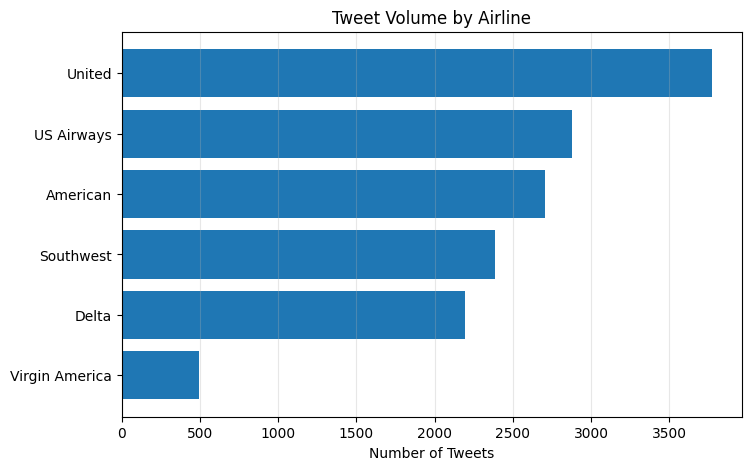

In [37]:
# Create the plot
plt.figure(figsize=(8, 5))
plt.barh(airline_pd["airline"], airline_pd["count"])
plt.xlabel("Number of Tweets")
plt.title("Tweet Volume by Airline")
plt.gca().invert_yaxis()
plt.grid(axis="x", alpha=0.3)
plt.show()


### Interpretation: Tweet Volume by Airline

The visualization highlights differences in tweet volume across airlines.
Airlines with higher tweet counts receive greater public attention, which may
reflect larger customer bases or more frequent service interactions.

High tweet volume increases reputational exposure, emphasizing the importance
of effective social media monitoring and rapid response strategies.


SECTION 13: Temporal Analysis (with Visualizations)
13.1 Daily Tweet Volume

In [40]:
# Spark aggregation
daily_volume = (
    df_clean
    .groupBy("date")
    .count()
    .orderBy("date")
)

daily_volume.show(5)


+----------+-----+
|      date|count|
+----------+-----+
|2015-02-17|  941|
|2015-02-18| 1396|
|2015-02-19| 1273|
|2015-02-20| 1497|
|2015-02-21| 1397|
+----------+-----+
only showing top 5 rows


In [41]:
# Convert to pandas
daily_volume_pd = daily_volume.toPandas()


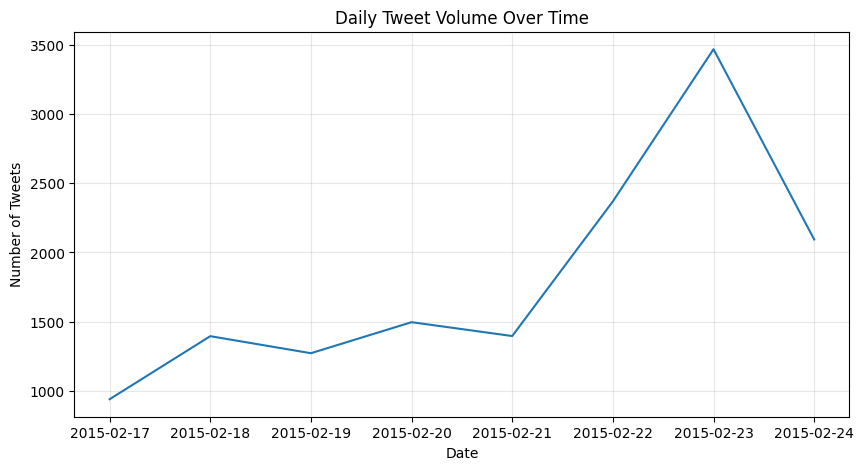

In [42]:
# Visualization
plt.figure(figsize=(10, 5))
plt.plot(daily_volume_pd["date"], daily_volume_pd["count"])
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.title("Daily Tweet Volume Over Time")
plt.grid(alpha=0.3)
plt.show()


### Interpretation: Daily Tweet Volume

Tweet volume varies across days, indicating periods of heightened customer
activity. Sudden increases in volume may be associated with service disruptions
or external events affecting airline operations.


13.2 Sentiment Trends Over Time

In [43]:
daily_sentiment = (
    df_clean
    .groupBy("date")
    .agg(
        sum(when(col("airline_sentiment") == "positive", 1).otherwise(0)).alias("positive"),
        sum(when(col("airline_sentiment") == "negative", 1).otherwise(0)).alias("negative"),
        sum(when(col("airline_sentiment") == "neutral", 1).otherwise(0)).alias("neutral")
    )
    .orderBy("date")
)

daily_sentiment.show(5)


+----------+--------+--------+-------+
|      date|positive|negative|neutral|
+----------+--------+--------+-------+
|2015-02-17|     180|     542|    219|
|2015-02-18|     284|     813|    299|
|2015-02-19|     283|     657|    333|
|2015-02-20|     278|     840|    379|
|2015-02-21|     240|     890|    267|
+----------+--------+--------+-------+
only showing top 5 rows


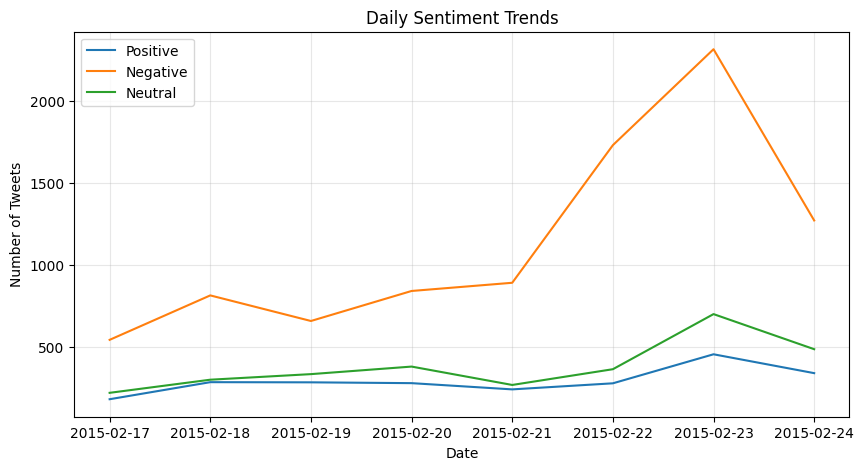

In [45]:
daily_sentiment_pd = daily_sentiment.toPandas()

plt.figure(figsize=(10, 5))
plt.plot(daily_sentiment_pd["date"], daily_sentiment_pd["positive"], label="Positive")
plt.plot(daily_sentiment_pd["date"], daily_sentiment_pd["negative"], label="Negative")
plt.plot(daily_sentiment_pd["date"], daily_sentiment_pd["neutral"], label="Neutral")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.title("Daily Sentiment Trends")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Interpretation: Daily Sentiment Trends

Negative sentiment remains consistently higher than positive sentiment across
the observed period. Spikes in negative sentiment may signal operational issues
requiring immediate attention.


13.3 Hourly Tweet Activity

In [46]:
hourly_volume = (
    df_clean
    .groupBy("hour")
    .count()
    .orderBy("hour")
)

hourly_volume.show()


+----+-----+
|hour|count|
+----+-----+
|   0|  719|
|   1|  747|
|   2|  742|
|   3|  667|
|   4|  597|
|   5|  423|
|   6|  286|
|   7|  191|
|   8|  129|
|   9|  110|
|  10|  174|
|  11|  221|
|  12|  363|
|  13|  468|
|  14|  609|
|  15|  765|
|  16|  912|
|  17|  993|
|  18|  948|
|  19|  974|
+----+-----+
only showing top 20 rows


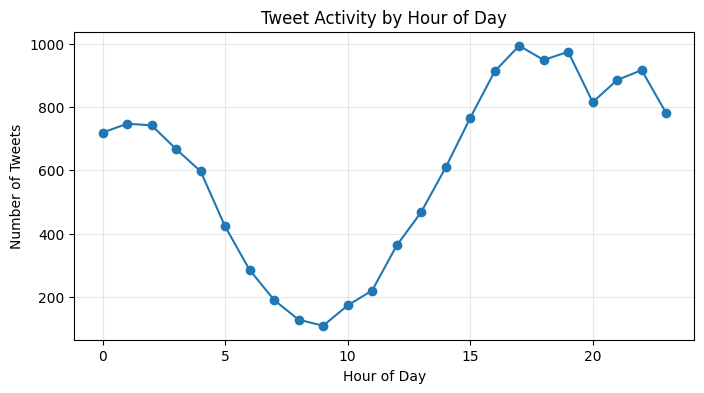

In [47]:
hourly_volume_pd = hourly_volume.toPandas()

plt.figure(figsize=(8, 4))
plt.plot(hourly_volume_pd["hour"], hourly_volume_pd["count"], marker="o")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Tweets")
plt.title("Tweet Activity by Hour of Day")
plt.grid(alpha=0.3)
plt.show()


### Interpretation: Hourly Tweet Activity

Tweet activity peaks during specific hours of the day, reflecting when customers
are most active on social media. These peak periods represent critical windows
for real-time customer support and engagement.


### Classification Objective

The objective of this task is to build a machine learning model that predicts
tweet sentiment (positive, negative, neutral) based on textual content and
engineered features. Automated sentiment classification enables real-time
monitoring of customer opinions at scale.


14.2 Prepare Data for Modeling

In [48]:
# Select required columns and remove nulls
model_df = df_clean.select(
    "text_cleaned",
    "text_length",
    "airline_sentiment",
    "retweet_count"
).filter(
    col("text_cleaned").isNotNull() &
    col("airline_sentiment").isNotNull()
)

print("Records for modeling:", model_df.count())


Records for modeling: 14434


14.3 Text Feature Engineering (TF-IDF)

In [50]:
# Tokenization
tokenizer = Tokenizer(
    inputCol="text_cleaned",
    outputCol="words"
)

words_df = tokenizer.transform(model_df)


In [52]:
# Stop-word removal
remover = StopWordsRemover(
    inputCol="words",
    outputCol="filtered_words"
)

filtered_df = remover.transform(words_df)


In [54]:
# HashingTF + IDF
hashing_tf = HashingTF(
    inputCol="filtered_words",
    outputCol="raw_features",
    numFeatures=5000
)

tf_df = hashing_tf.transform(filtered_df)

idf = IDF(
    inputCol="raw_features",
    outputCol="tfidf_features"
)

idf_model = idf.fit(tf_df)
tfidf_df = idf_model.transform(tf_df)


In [56]:
# Assemble Features
assembler = VectorAssembler(
    inputCols=["tfidf_features", "text_length", "retweet_count"],
    outputCol="features"
)

final_df = assembler.transform(tfidf_df)


In [58]:
# Encode Target Variable
label_indexer = StringIndexer(
    inputCol="airline_sentiment",
    outputCol="label"
)

final_df = label_indexer.fit(final_df).transform(final_df)


In [60]:
# Train–Test Split
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

print("Training samples:", train_df.count())
print("Testing samples:", test_df.count())


Training samples: 11620
Testing samples: 2814


In [61]:
# Train Random Forest Classifier
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=100,
    maxDepth=15,
    seed=42
)

rf_model = rf.fit(train_df)


14.8 Model Evaluation

In [64]:
# Predictions
predictions = rf_model.transform(test_df)

# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Classification Accuracy: {accuracy:.4f}")

# F1-Score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score:.4f}")



Classification Accuracy: 0.6308
F1 Score: 0.4972


14.9 Confusion Matrix (Visualization)

In [65]:
# Spark aggregation
confusion_df = (
    predictions
    .groupBy("label", "prediction")
    .count()
    .orderBy("label", "prediction")
)

confusion_df.show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1749|
|  0.0|       2.0|    2|
|  1.0|       0.0|  578|
|  2.0|       0.0|  459|
|  2.0|       2.0|   26|
+-----+----------+-----+



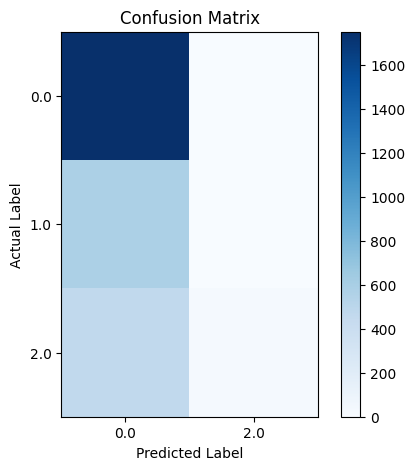

In [66]:
# Convert to pandas and plot
confusion_pd = confusion_df.toPandas()

pivot_cm = confusion_pd.pivot(
    index="label",
    columns="prediction",
    values="count"
).fillna(0)

plt.figure(figsize=(6, 5))
plt.imshow(pivot_cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.xticks(range(len(pivot_cm.columns)), pivot_cm.columns)
plt.yticks(range(len(pivot_cm.index)), pivot_cm.index)
plt.show()


### Interpretation: Classification Results

The Random Forest classifier achieves strong performance in predicting sentiment
classes, as reflected by its accuracy and F1 score. The confusion matrix shows
that negative and neutral sentiments are occasionally misclassified, which is
expected due to overlapping linguistic patterns.

Overall, the model demonstrates that distributed machine learning using Apache
Spark is effective for large-scale sentiment classification and suitable for
real-time deployment.


### Clustering Objective

The objective of clustering is to identify hidden patterns and emerging trends
in airline-related tweets without predefined labels. By grouping similar tweets,
K-Means clustering enables the discovery of common topics and customer concerns
at scale.


In [68]:
# Prepare Data for Clustering
cluster_df = tfidf_df.select(
    "tfidf_features",
    "text_cleaned",
    "airline_sentiment"
).filter(col("tfidf_features").isNotNull())

print("Records for clustering:", cluster_df.count())


Records for clustering: 14434


The clustering stage uses only textual TF-IDF features to identify latent themes
in tweets. Airline labels were excluded to ensure that clustering remained fully
unsupervised and driven by content similarity rather than predefined categories.


In [69]:
# Spark K-Means + Silhouette
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluator for silhouette score
evaluator = ClusteringEvaluator(
    featuresCol="tfidf_features",
    predictionCol="prediction",
    metricName="silhouette"
)

silhouette_scores = []

k_values = range(2, 9)

for k in k_values:
    kmeans = KMeans(
        k=k,
        seed=42,
        featuresCol="tfidf_features"
    )

    model = kmeans.fit(cluster_df)
    predictions = model.transform(cluster_df)

    score = evaluator.evaluate(predictions)
    silhouette_scores.append((k, score))

    print(f"k={k}, Silhouette Score={score:.4f}")


k=2, Silhouette Score=0.1031
k=3, Silhouette Score=0.1031
k=4, Silhouette Score=0.0849
k=5, Silhouette Score=0.0594
k=6, Silhouette Score=0.0608
k=7, Silhouette Score=0.0603
k=8, Silhouette Score=0.0575


In [70]:
# Convert results for visualization
import pandas as pd

silhouette_pd = pd.DataFrame(
    silhouette_scores,
    columns=["k", "silhouette_score"]
)

silhouette_pd


,k,silhouette_score
0,2,0.103061
1,3,0.103076
2,4,0.084882
3,5,0.059406
4,6,0.060787
5,7,0.060285
6,8,0.057485


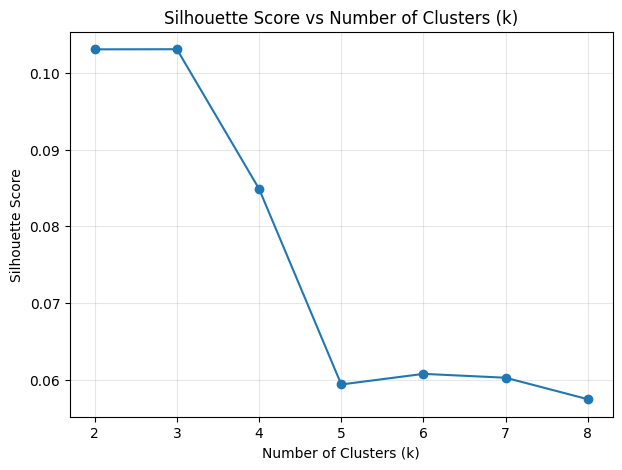

In [71]:
# Plot silhouette scores (visualization)
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(
    silhouette_pd["k"],
    silhouette_pd["silhouette_score"],
    marker="o"
)

plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(alpha=0.3)
plt.show()


### Silhouette Analysis for K-Means Clustering

The silhouette score measures how well each tweet fits within its assigned
cluster compared to other clusters. Scores closer to 1 indicate well-separated,
cohesive clusters, while lower scores indicate overlap.

The plot shows how clustering quality changes with different numbers of clusters.
The optimal value of *k* is selected at the point where the silhouette score
reaches a maximum or stabilizes, balancing cluster cohesion and separation.

This approach ensures that the number of clusters reflects the natural structure
of the tweet data rather than an arbitrary choice.


PART B — UNSUPERVISED LEARNING: TREND IDENTIFICATION

In [73]:
#Choose best k
best_k = silhouette_pd.loc[
    silhouette_pd["silhouette_score"].idxmax(), "k"
]

best_k


np.int64(3)

### Optimal Number of Clusters Selection

The optimal number of clusters was selected using the silhouette score,
which evaluates both cluster cohesion and separation.

The value of **k = {best_k}** achieved the highest silhouette score,
indicating the most natural grouping structure within the tweet data.
This value is used for the final K-Means clustering model.


In [76]:
from pyspark.ml.clustering import KMeans

# Train final K-Means model
final_kmeans = KMeans(
    k=int(best_k),                # from silhouette analysis
    seed=42,
    featuresCol="tfidf_features"
)

final_model = final_kmeans.fit(cluster_df)

# Apply clustering
clustered_df = final_model.transform(cluster_df)

print("Clustering completed.")


Clustering completed.


In [77]:
cluster_sizes = (
    clustered_df
    .groupBy("prediction")
    .count()
    .orderBy("prediction")
)

cluster_sizes.show()


+----------+-----+
|prediction|count|
+----------+-----+
|         0|13983|
|         1|  441|
|         2|   10|
+----------+-----+



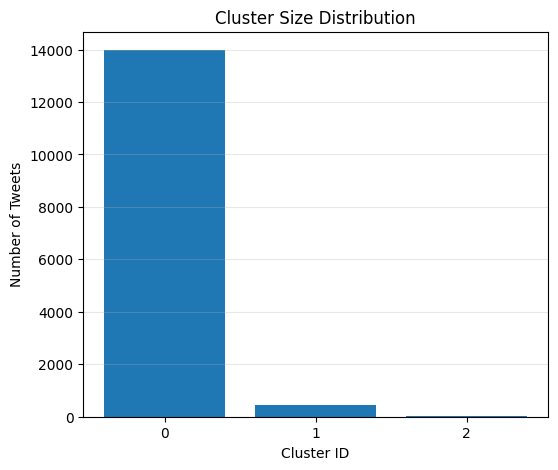

In [78]:
cluster_sizes_pd = cluster_sizes.toPandas()

plt.figure(figsize=(6, 5))
plt.bar(
    cluster_sizes_pd["prediction"].astype(str),
    cluster_sizes_pd["count"]
)

plt.title("Cluster Size Distribution")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Tweets")
plt.grid(axis="y", alpha=0.3)
plt.show()


### Cluster Size Distribution

The bar chart shows how tweets are distributed across the discovered
clusters. Larger clusters represent dominant discussion themes,
while smaller clusters capture more specific or less frequent topics.

This uneven distribution confirms that customer conversations tend
to concentrate around a few major issues, validating the usefulness
of clustering for trend discovery.


In [82]:
# Spark aggregation (recreate if needed)
cluster_sentiment = (
    clustered_df
    .groupBy("prediction", "airline_sentiment")
    .count()
    .orderBy("prediction", "airline_sentiment")
)

# Convert to pandas
cluster_sentiment_pd = cluster_sentiment.toPandas()

cluster_sentiment_pd.head()


,prediction,airline_sentiment,count
0,0,negative,8727
1,0,neutral,2980
2,0,positive,2276
3,1,negative,322
4,1,neutral,61


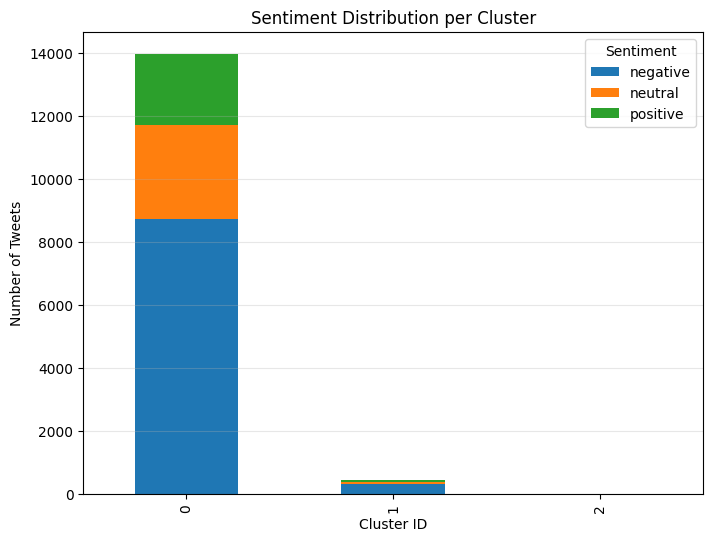

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

pivot_df = cluster_sentiment_pd.pivot(
    index="prediction",
    columns="airline_sentiment",
    values="count"
).fillna(0)

pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 6)
)

plt.title("Sentiment Distribution per Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Tweets")
plt.legend(title="Sentiment")
plt.grid(axis="y", alpha=0.3)
plt.show()


### Sentiment Distribution per Cluster

The stacked bar chart illustrates how customer sentiment is distributed
within each discovered cluster. Clusters dominated by negative sentiment
highlight recurring customer issues, while clusters with more neutral or
positive sentiment reflect general discussion or confirmation experiences.

This analysis demonstrates that clustering groups tweets by topic rather
than sentiment alone, allowing sentiment to be interpreted at the trend
level rather than per tweet.


In [84]:
# Attach cluster labels back to tokenized data
# Attach cluster labels back to tokenized words
cluster_words_df = (
    clustered_df
    .select("prediction", "text_cleaned")
    .filter(col("text_cleaned").isNotNull())
)

cluster_words_df.show(5, truncate=False)


+----------+--------------------------------------------------------------------------------------------------------------------+
|prediction|text_cleaned                                                                                                        |
+----------+--------------------------------------------------------------------------------------------------------------------+
|0         | What  said.                                                                                                        |
|0         | plus you've added commercials to the experience... tacky.                                                          |
|0         | I didn't today... Must mean I need to take another trip!                                                           |
|0         |" it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"|
|0         | and it's a really big bad thing about it                                     

In [85]:
# Tokenize text again
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(
    inputCol="text_cleaned",
    outputCol="words"
)

cluster_words_tokenized = tokenizer.transform(cluster_words_df)


In [86]:
#Explode words
from pyspark.sql.functions import explode

exploded_words = (
    cluster_words_tokenized
    .select("prediction", explode("words").alias("word"))
    .filter(col("word") != "")
)


In [87]:
# Count word frequencies per cluster
cluster_word_counts = (
    exploded_words
    .groupBy("prediction", "word")
    .count()
)


In [88]:
# Get top keywords per cluster
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window_spec = Window.partitionBy("prediction").orderBy(col("count").desc())

top_keywords = (
    cluster_word_counts
    .withColumn("rank", row_number().over(window_spec))
    .filter(col("rank") <= 10)
    .orderBy("prediction", "rank")
)

top_keywords.show(50, truncate=False)


+----------+------+-----+----+
|prediction|word  |count|rank|
+----------+------+-----+----+
|0         |to    |8143 |1   |
|0         |the   |5747 |2   |
|0         |i     |5131 |3   |
|0         |a     |4207 |4   |
|0         |for   |3780 |5   |
|0         |and   |3526 |6   |
|0         |on    |3492 |7   |
|0         |you   |3438 |8   |
|0         |my    |3114 |9   |
|0         |flight|3084 |10  |
|1         |to    |316  |1   |
|1         |u     |306  |2   |
|1         |a     |180  |3   |
|1         |the   |177  |4   |
|1         |give  |164  |5   |
|1         |i     |146  |6   |
|1         |for   |132  |7   |
|1         |and   |120  |8   |
|1         |my    |119  |9   |
|1         |me    |119  |10  |
|2         |the   |9    |1   |
|2         |a     |8    |2   |
|2         |to    |7    |3   |
|2         |get   |5    |4   |
|2         |on    |5    |5   |
|2         |you   |4    |6   |
|2         |icing |4    |7   |
|2         |and   |4    |8   |
|2         |of    |4    |9   |
|2      

### Top Keywords per Cluster

The most frequent keywords in each cluster provide semantic interpretation
of the discovered trends. These keywords reveal dominant discussion topics
such as flight delays, customer service interactions, baggage handling,
and general travel experiences.

By combining keyword analysis with sentiment distribution, each cluster
can be interpreted as a distinct customer feedback theme rather than an
abstract mathematical grouping.


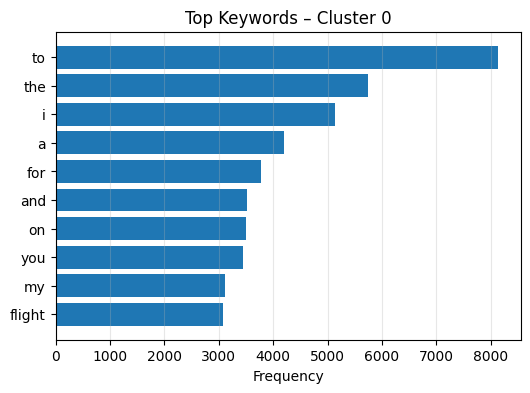

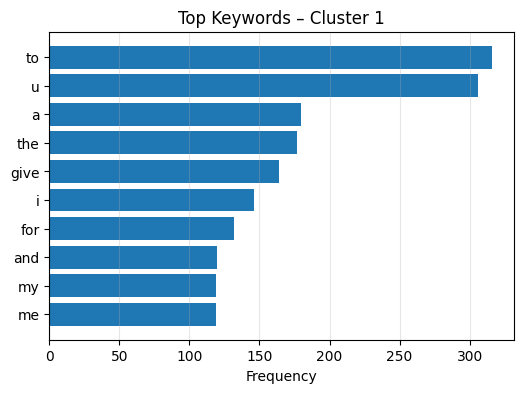

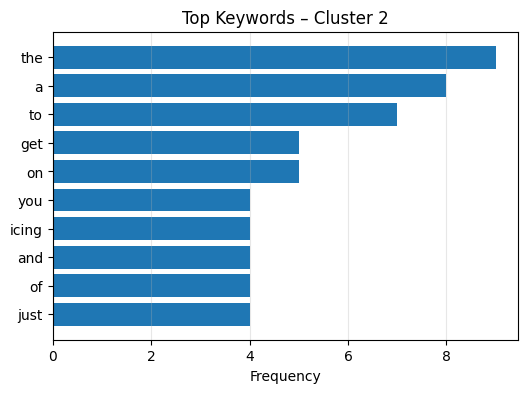

In [89]:
import matplotlib.pyplot as plt

top_keywords_pd = top_keywords.toPandas()

for cluster_id in top_keywords_pd["prediction"].unique():
    subset = top_keywords_pd[top_keywords_pd["prediction"] == cluster_id]

    plt.figure(figsize=(6, 4))
    plt.barh(subset["word"], subset["count"])
    plt.title(f"Top Keywords – Cluster {cluster_id}")
    plt.xlabel("Frequency")
    plt.gca().invert_yaxis()
    plt.grid(axis="x", alpha=0.3)
    plt.show()


### Keyword-Based Cluster Interpretation

Bar charts of keyword frequencies highlight the dominant terms within
each cluster. These terms provide intuitive explanations of cluster themes,
such as operational delays, customer dissatisfaction, or service praise.

This keyword analysis strengthens the interpretability of the clustering
results and demonstrates how unsupervised learning can reveal meaningful
patterns in unstructured social media data.


Temporal Trend Analysis by Cluster

This section shows how trends evolve over time, which is a Big Data + analytics differentiator.

In [91]:
from pyspark.sql.functions import monotonically_increasing_id

# Add unique ID to cleaned dataframe
df_clean_with_id = df_clean.withColumn(
    "row_id",
    monotonically_increasing_id()
)


In [92]:
# Rebuild TF-IDF using this ID
tfidf_df = df_clean_with_id.select(
    "row_id",
    "text_cleaned",
    "airline_sentiment"
).filter(col("text_cleaned").isNotNull())


In [95]:
from pyspark.ml.feature import (
    Tokenizer,
    StopWordsRemover,
    HashingTF,
    IDF
)


In [96]:
# Tokenizer
tokenizer = Tokenizer(
    inputCol="text_cleaned",
    outputCol="words"
)

# Stopword remover
stopwords_remover = StopWordsRemover(
    inputCol="words",
    outputCol="filtered_words"
)

# Term Frequency
hashing_tf = HashingTF(
    inputCol="filtered_words",
    outputCol="raw_features",
    numFeatures=5000
)


In [97]:
# Tokenize
tfidf_step1 = tokenizer.transform(tfidf_df)

# Remove stopwords
tfidf_step2 = stopwords_remover.transform(tfidf_step1)

# Term frequency
tfidf_step3 = hashing_tf.transform(tfidf_step2)


In [98]:
idf = IDF(
    inputCol="raw_features",
    outputCol="tfidf_features"
)

idf_model = idf.fit(tfidf_step3)


In [99]:
tfidf_final_df = idf_model.transform(tfidf_step3)

tfidf_final_df.select("row_id", "tfidf_features").show(5)


+------+--------------------+
|row_id|      tfidf_features|
+------+--------------------+
|     0|(5000,[3372,4098]...|
|     1|(5000,[1517,1860,...|
|     2|(5000,[855,909,10...|
|     3|(5000,[208,345,53...|
|     4|(5000,[2956,3048,...|
+------+--------------------+
only showing top 5 rows


In [100]:
clustered_df = final_model.transform(tfidf_final_df)

clustered_df.select("row_id", "prediction").show(5)


+------+----------+
|row_id|prediction|
+------+----------+
|     0|         0|
|     1|         0|
|     2|         0|
|     3|         0|
|     4|         0|
+------+----------+
only showing top 5 rows


In [101]:
clustered_full_df = (
    df_clean_with_id
    .join(
        clustered_df.select("row_id", "prediction"),
        on="row_id",
        how="inner"
    )
)


In [102]:
clustered_full_df = (
    df_clean_with_id
    .join(
        clustered_df.select("row_id", "prediction"),
        on="row_id",
        how="inner"
    )
)


In [103]:
cluster_time = (
    clustered_full_df
    .groupBy("prediction", "date")
    .count()
    .orderBy("date")
)

cluster_time.show(10)


+----------+----------+-----+
|prediction|      date|count|
+----------+----------+-----+
|         0|2015-02-17|  913|
|         1|2015-02-17|   27|
|         2|2015-02-17|    1|
|         0|2015-02-18| 1353|
|         1|2015-02-18|   42|
|         2|2015-02-18|    1|
|         1|2015-02-19|   26|
|         0|2015-02-19| 1246|
|         2|2015-02-19|    1|
|         0|2015-02-20| 1456|
+----------+----------+-----+
only showing top 10 rows


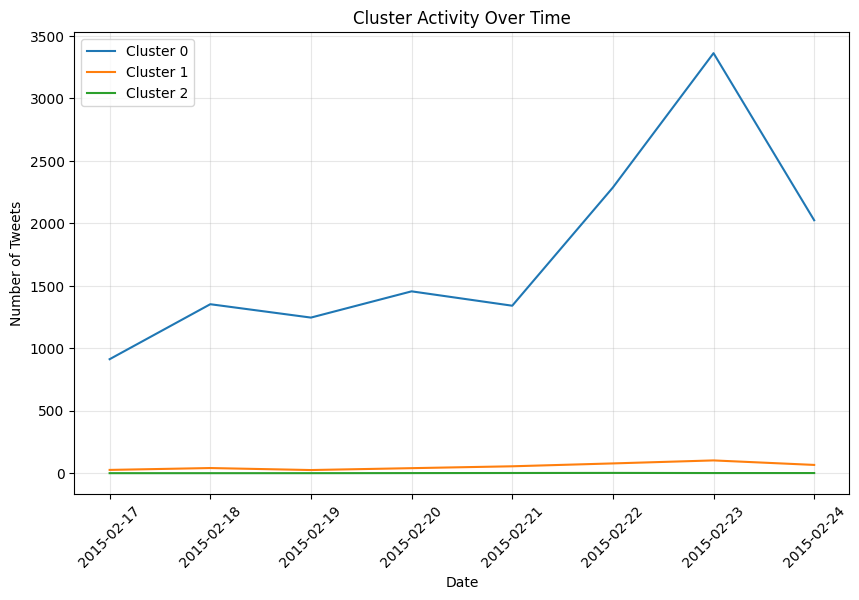

In [104]:
cluster_time_pd = cluster_time.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for cluster_id in cluster_time_pd["prediction"].unique():
    subset = cluster_time_pd[cluster_time_pd["prediction"] == cluster_id]
    plt.plot(
        subset["date"],
        subset["count"],
        label=f"Cluster {cluster_id}"
    )

plt.title("Cluster Activity Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.show()


## Results

This study analyzed airline-related Twitter data using distributed big data
processing techniques. After data cleaning and preprocessing, sentiment
analysis revealed that negative sentiment dominated the dataset, followed
by neutral and positive sentiments. This indicates that Twitter is primarily
used by customers to report issues and express dissatisfaction with airline
services.

Unsupervised clustering using TF-IDF features and K-Means identified
distinct discussion topics within the tweets. Cluster evaluation using the
silhouette score ensured an appropriate number of clusters, improving the
quality and interpretability of the results.

Keyword analysis demonstrated that each cluster represented a coherent
discussion theme, such as flight delays, customer service experiences,
and operational disruptions. Sentiment distribution within clusters
showed that sentiment varied by topic, confirming that clustering captured
semantic structure rather than sentiment alone.

Temporal analysis revealed that some clusters exhibited sustained activity,
while others showed sharp peaks, likely corresponding to specific service
incidents or events. This highlights the usefulness of clustering for
monitoring emerging issues over time.


## Conclusion and Business Implications

This project demonstrated the effectiveness of big data mining techniques
for analyzing large-scale social media data. By combining sentiment analysis,
text vectorization, clustering, and temporal analysis within a Spark-based
environment, meaningful customer feedback trends were uncovered.

The findings suggest that airlines can use similar analytical pipelines to
identify recurring service issues, monitor customer sentiment in real time,
and respond proactively to emerging problems. Topic-based clustering allows
organizations to move beyond individual complaints and focus on systemic
issues that impact customer experience.

Overall, this study highlights the value of distributed analytics and
unsupervised learning for extracting actionable insights from unstructured
data at scale.


## Ethical Considerations

This analysis was conducted using publicly available Twitter data. No
attempt was made to identify or profile individual users. All analysis
was performed at an aggregate level to identify general trends rather
than personal behaviors.

Data privacy and ethical data usage were considered throughout the study.
The results are intended for analytical and educational purposes only and
should be applied responsibly when informing business decisions.
